In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.metrics import R2Score

In [366]:

def read_invest_com_crypto_data(csv_file_path):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file_path, thousands=",")
        
        # Ensure the 'timestamp' column is in datetime format
        df['timestamp'] = pd.to_datetime(df['Date'])
        # Set the timestamp as the index
        df.set_index('timestamp', inplace=True)
        train_date_series = df['Date'].values
        return df.loc[:, ~df.columns.isin(["Vol.", "Change %"])]
    
    except FileNotFoundError:
        print("Error: The specified CSV file was not found.")
        return None
    
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
        return None
    
    except pd.errors.ParserError:
        print("Error: An error occurred while parsing the CSV file.")
        return None


In [518]:
# Fetch Ripple price data
df = read_invest_com_crypto_data("XRP Historical Data.csv")

#dataCutoff = int(len(df) * 0.3)
dataCutoff = 270
print("Cutoff: ", dataCutoff)

train_date_series = df['Date'][:-dataCutoff]
test_date_series = df['Date'][-dataCutoff:]

df = df.loc[:, df.columns != 'Date']

train_data = df["Price"][:-dataCutoff].values.reshape(-1, 1)
testData = df["Price"][-dataCutoff:].values.reshape(-1, 1)

print(f"Train Data: {train_data.shape}\nTest Data: {testData.shape}")

train_target = train_data
test_target = testData
print(f"Train Target: {train_target.shape}\nTest Data: {test_target.shape}")

Cutoff:  270
Train Data: (3359, 1)
Test Data: (270, 1)
Train Target: (3359, 1)
Test Data: (270, 1)


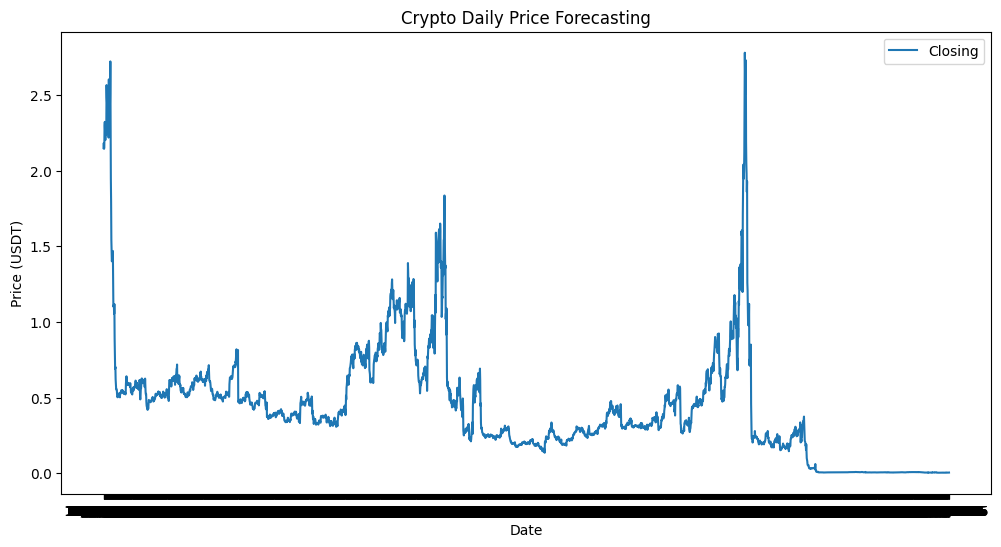

In [519]:
# Plot train data
plt.figure(figsize=(12, 6))
plt.plot(train_date_series, train_data, label='Closing')
plt.title('Crypto Daily Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

### Normalization
- Scales the input data between (0, 1)
- I think MinMax only can be used also
- it's important to keep the scaling parameters!

In [520]:
# Normalize the data
scaler = RobustScaler()
normalized_data = scaler.fit_transform(train_data)
print(normalized_data.shape)


(3359, 1)


In [521]:
normalized_data

array([[ 5.00805198],
       [ 5.10298065],
       [ 4.9961859 ],
       ...,
       [-1.05240853],
       [-1.05184348],
       [-1.0509959 ]])

In [522]:
# Function to prepare data for LSTM
def prepare_data(normalized_data, target, data, seq_len):
    X, y = [], []
    for i in range(len(normalized_data) - seq_len):
        X.append(normalized_data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y), data[:-seq_len]


In [523]:
# Prepare data for each EWT component
seq_len = 90  # 24 hours for daily predictions
X, y, train_data = prepare_data(normalized_data, train_target, train_data, seq_len)

y = y.reshape(-1, 1)
train_date_series= train_date_series[:-seq_len]
print(y.shape, X.shape, train_date_series.shape)

(3269, 1) (3269, 90, 1) (3269,)


In [524]:
# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [525]:
# Train separate LSTM models for each EWT component
model = create_lstm_model((seq_len, 1))
model.fit(X, y, epochs=100, verbose=0, )


In [510]:
# Make predictions
predictions = np.zeros_like(y)
for i in range(seq_len, len(y)):
    print(i)
    inputs = normalized_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    predictions[i] = pred


90
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
(1, 1)
91
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(1, 1)
92
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(1, 1)
93
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(1, 1)
94
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(1, 1)
95
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 1)
96
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(1, 1)
97
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 1)
98
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 1)
99
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 1)
100
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 1)
101
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1)
102
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(1, 1)
103
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(1, 1)
104
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 1)
105
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(1, 1)
106
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(1, 1)
107
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [513]:
print(train_date_series.shape, train_data.shape, predictions.shape)

(2253,) (2253, 1) (2451, 1)


ValueError: x and y must have same first dimension, but have shapes (2163,) and (2361, 1)

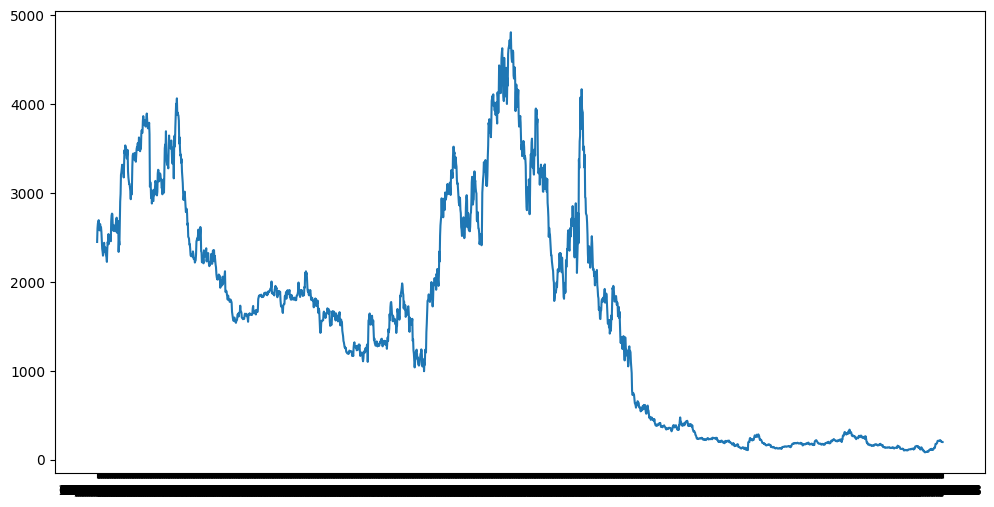

In [512]:
reshaped = predictions.reshape(-1, 1)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(train_date_series[seq_len:], train_data[seq_len:], label='Actual Price')
plt.plot(train_date_series[seq_len:], reshaped[seq_len:], label='Predictions')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()


In [ ]:
# Evaluate the model
mse = np.mean((train_data[seq_len:] - reshaped[seq_len:]) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(train_data[seq_len:] - reshaped[seq_len:]))
mape = np.mean(np.abs((train_data[seq_len:] - reshaped[seq_len:]) / train_data[seq_len:])) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 0.0362
MAE: 0.0192
MAPE: 3.6423


In [526]:
normalized_test_data = scaler.transform(testData)
X_test, y_test, testData = prepare_data(normalized_test_data, test_target, testData, seq_len)
y_test = y_test.reshape(-1, 1)
y_test.shape
print(testData.shape)

(180, 1)


In [528]:
# Make test predictions
print(len(y_test) - 1)
test_predictions = np.zeros_like(y_test)
for i in range(seq_len, len(y_test)):
    print(i)
    inputs = normalized_test_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    test_predictions[i] = pred

179
90
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
(1, 1)
91
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
(1, 1)
92
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
(1, 1)
93
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
(1, 1)
94
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
(1, 1)
95
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
(1, 1)
96
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
(1, 1)
97
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
(1, 1)
98
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(1, 1)
99
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
(1, 1)
100
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
(1, 1)
101
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(1, 1)
102
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
(1, 1)
103
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
(1, 1)
104
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
(1, 1)
105
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(1, 1)
106
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(1, 1)
107
(90, 1)
1/1 ━━━━━━━━━━━━━━━━━━━

(270,) (180, 1) (180, 1)


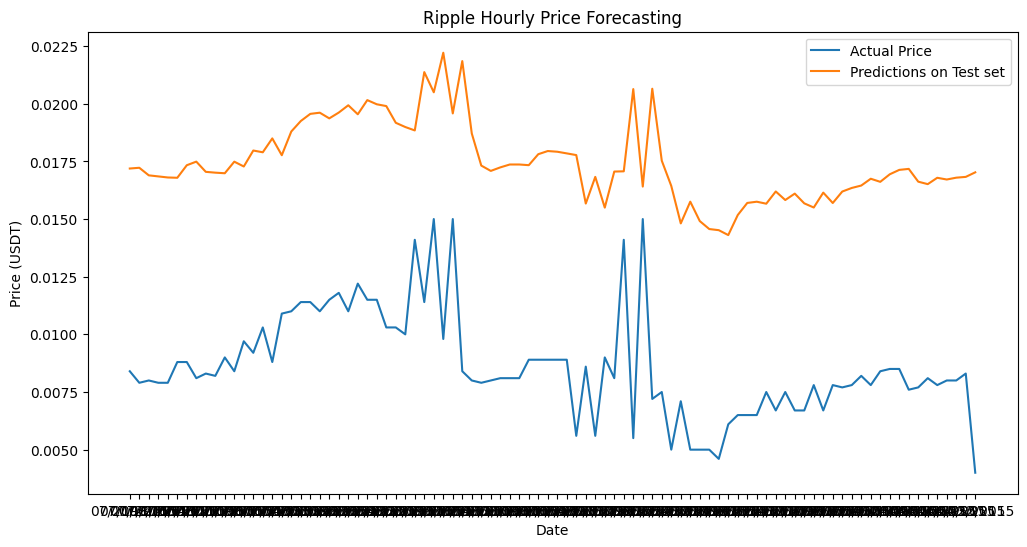

In [529]:
test_reshaped = test_predictions.reshape(-1, 1)
print(test_date_series.shape, testData.shape, test_reshaped.shape)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(test_date_series[seq_len:-seq_len], testData[seq_len:], label='Actual Price')
plt.plot(test_date_series[seq_len:-seq_len], test_reshaped[seq_len:], label='Predictions on Test set')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

In [530]:
# Evaluate the model 
r2 = R2Score()
testDataToUse = testData[seq_len:]
testPredictionsToUse = test_reshaped[seq_len:]
print(testDataToUse.shape, testPredictionsToUse.shape)

r2.update_state(testDataToUse, testPredictionsToUse)
r2.result().numpy()

mse = np.mean((testDataToUse - testPredictionsToUse) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(testDataToUse - testPredictionsToUse))
mape = np.mean(np.abs((testDataToUse - testPredictionsToUse) / testDataToUse)) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"accuracy: {r2.result().numpy()}")

(90, 1) (90, 1)
RMSE: 0.0090
MAE: 0.0088
MAPE: 113.3004
accuracy: -14.848655700683594
